- 2018/08/30 additional triggers `HLT_Mu38NoFiltersNoVtxDisplaced_Photon38_CaloIdL_v` for 2mu2e signals

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.trigger import Triggers

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from os.path import join
import os
import json
datasets = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e.json')))

In [3]:
class triggerBitProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        trgbits_axis = hist.Bin('tb', 'trigger firing', 2, 0, 2)
        self._accumulator = processor.dict_accumulator({
            'doublemu': hist.Hist('#counts', dataset_axis, trgbits_axis),
            'muphoton': hist.Hist('#counts', dataset_axis, trgbits_axis),
            'orboth': hist.Hist('#counts', dataset_axis, trgbits_axis),
            'triggercounts': processor.defaultdict_accumulator(int),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset=df['dataset']
        
        doublemubit = np.logical_or.reduce([df[tp] for tp in Triggers])
        muphotonbit = df['HLT_Mu38NoFiltersNoVtxDisplaced_Photon38_CaloIdL']
        
        output['doublemu'].fill(dataset=dataset, tb=doublemubit.astype(int))
        output['muphoton'].fill(dataset=dataset, tb=muphotonbit.astype(int))
        output['orboth'].fill(dataset=dataset, tb=(doublemubit|muphotonbit).astype(int))
        
        output['triggercounts']['numevents__'+dataset] += df.size
        output['triggercounts']['doublemu__'+dataset] += doublemubit.sum()
        output['triggercounts']['muphoton__'+dataset] += muphotonbit.sum()
        output['triggercounts']['~doublemu&muphoton__'+dataset] += (~doublemubit & muphotonbit).sum()
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=triggerBitProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   2%|▏         | 2/95 [00:01<00:46,  1.99items/s]


KeyError: 'HLT_Mu38NoFiltersNoVtxDisplaced_Photon38_CaloIdL'

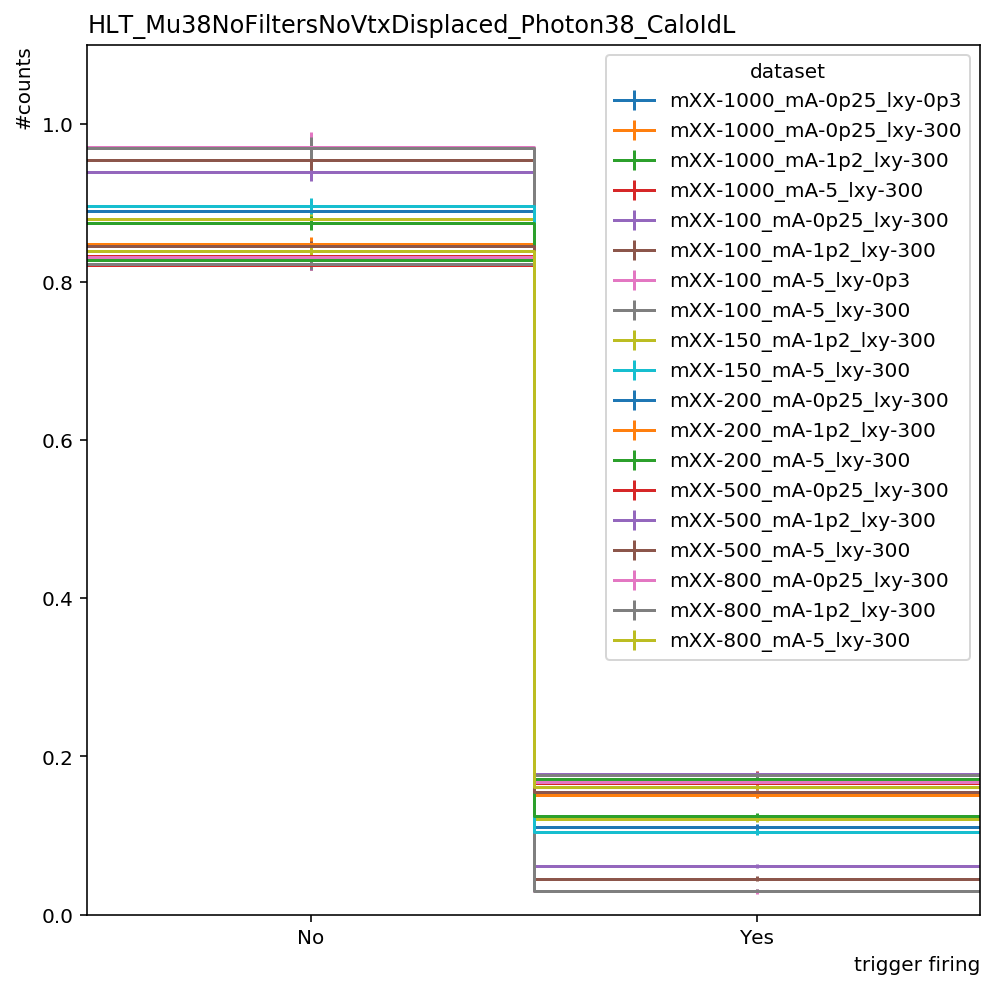

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
hist.plot1d(output['muphoton'], overlay='dataset', ax=ax, density=True, )
ax.set_title('HLT_Mu38NoFiltersNoVtxDisplaced_Photon38_CaloIdL', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['No', 'Yes'])
ax.set_ylim([0, 1.1]);

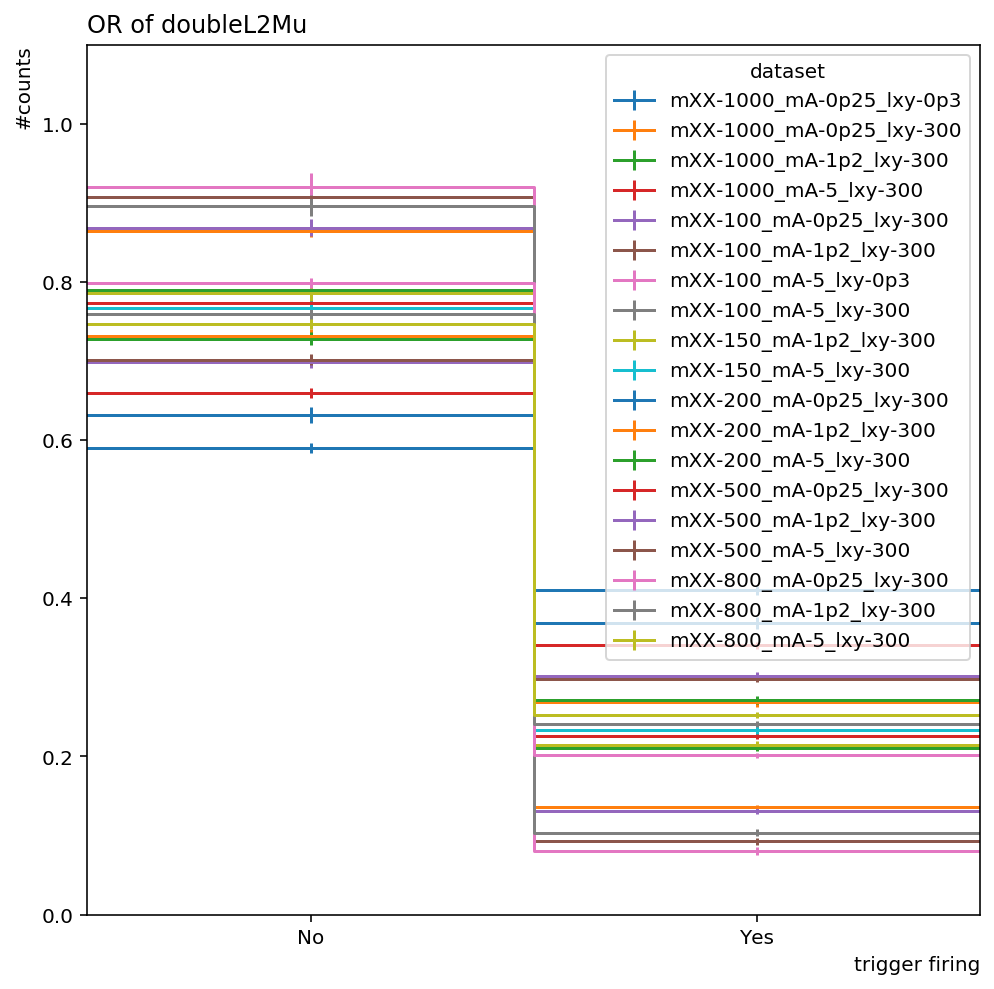

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
hist.plot1d(output['doublemu'], overlay='dataset', ax=ax, density=True, )
ax.set_title('OR of doubleL2Mu', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['No', 'Yes'])
ax.set_ylim([0, 1.1]);

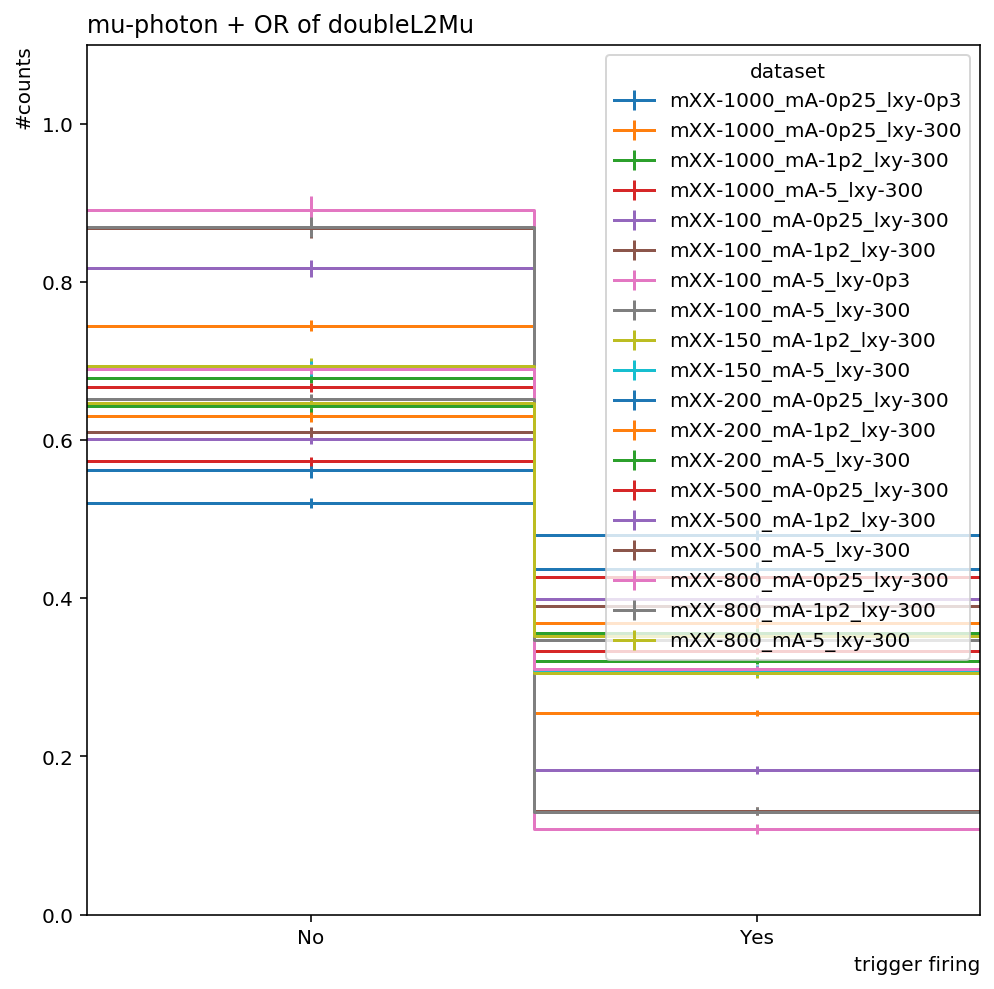

In [69]:
fig, ax = plt.subplots(figsize=(8,8))
hist.plot1d(output['orboth'], overlay='dataset', ax=ax, density=True, )
ax.set_title('mu-photon + OR of doubleL2Mu', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['No', 'Yes'])
ax.set_ylim([0, 1.1]);

In [61]:
from collections import defaultdict
result = defaultdict(dict)
for k in output['triggercounts']:
    row, col = k.split('__')
    result[row][col] = output['triggercounts'][k]

In [62]:
import pandas as pd
df = pd.DataFrame(result)

In [64]:
df['muphoton additional gain'] = df['~doublemu&muphoton']/df['doublemu']

In [65]:
df

,numevents,doublemu,muphoton,~doublemu&muphoton,muphoton additional gain
mXX-1000_mA-0p25_lxy-0p3,5902,2175,653,408,0.187586
mXX-1000_mA-0p25_lxy-300,17258,2342,2778,2062,0.880444
mXX-1000_mA-1p2_lxy-300,17901,3770,3080,1981,0.525464
mXX-1000_mA-5_lxy-300,18012,4069,3005,1934,0.475301
mXX-100_mA-0p25_lxy-300,7679,1010,470,394,0.390099
mXX-100_mA-1p2_lxy-300,5208,482,235,202,0.419087
mXX-100_mA-5_lxy-0p3,2935,236,86,82,0.347458
mXX-100_mA-5_lxy-300,5325,552,162,142,0.257246
mXX-150_mA-1p2_lxy-300,8144,1745,984,747,0.428080
mXX-150_mA-5_lxy-300,8341,1947,868,636,0.326656


In [71]:
df['muphoton']/df['numevents']

mXX-1000_mA-0p25_lxy-0p3    0.110640
mXX-1000_mA-0p25_lxy-300    0.160969
mXX-1000_mA-1p2_lxy-300     0.172057
mXX-1000_mA-5_lxy-300       0.166833
mXX-100_mA-0p25_lxy-300     0.061206
mXX-100_mA-1p2_lxy-300      0.045123
mXX-100_mA-5_lxy-0p3        0.029302
mXX-100_mA-5_lxy-300        0.030423
mXX-150_mA-1p2_lxy-300      0.120825
mXX-150_mA-5_lxy-300        0.104064
mXX-200_mA-0p25_lxy-300     0.152082
mXX-200_mA-1p2_lxy-300      0.151891
mXX-200_mA-5_lxy-300        0.125331
mXX-500_mA-0p25_lxy-300     0.178217
mXX-500_mA-1p2_lxy-300      0.177341
mXX-500_mA-5_lxy-300        0.154894
mXX-800_mA-0p25_lxy-300     0.167879
mXX-800_mA-1p2_lxy-300      0.177138
mXX-800_mA-5_lxy-300        0.161300
dtype: float64